# **Notebook 3 : Entraînement du Modèle RNN**

Dans ce notebook, nous entraînons un modèle de réseau neuronal récurrent (**RNN**) pour analyser les descriptions textuelles associées aux images. Les étapes principales sont :

- **Chargement des Séquences Prétraitées :** Nous utilisons les séquences de texte préparées dans le Notebook 1.
- **Création du Modèle RNN :** Nous construisons un modèle avec les composants suivants :
  - **Couche Embedding :** Pour convertir les indices de mots en vecteurs denses de dimension fixe.
  - **Couche LSTM :** Pour capturer les dépendances séquentielles et contextuelles dans les légendes.
  - **Couches Fully Connected :** Pour effectuer la classification multi-label.
- **Compilation du Modèle :** Nous utilisons la fonction de perte `binary_crossentropy` et la métrique `binary_accuracy` adaptée à la classification multi-label.
- **Entraînement du Modèle :** Nous entraînons le modèle sur les données d'entraînement et évaluons sa performance sur les données de test.
- **Sauvegarde du Modèle :** Nous sauvegardons le modèle entraîné pour une utilisation ultérieure.

**Pourquoi ?**

Les LSTM sont efficaces pour traiter les données séquentielles comme le texte, car ils peuvent conserver des informations sur de longues séquences. En analysant les descriptions textuelles, le modèle peut apprendre des représentations sémantiques utiles pour la classification.


In [65]:
# Import des bibliothèques nécessaires
import os
import numpy as np
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import matplotlib.pyplot as plt


In [66]:

# Chemins des données
data_dir = "../datasets/flickr8k/"

# Charger les fichiers sauvegardés dans le Notebook 1
with open(os.path.join(data_dir, "train_data.pkl"), "rb") as f:
    train_data = pickle.load(f)

with open(os.path.join(data_dir, "test_data.pkl"), "rb") as f:
        test_data = pickle.load(f)

with open(os.path.join(data_dir, "tokenizer.pkl"), "rb") as f:
        tokenizer = pickle.load(f)

with open(os.path.join(data_dir, "class_labels.pkl"), "rb") as f:
        class_labels = pickle.load(f)

print(f"Nombre d'exemples dans le dataset d'entraînement : {len(train_data)}")
print(f"Nombre d'exemples dans le dataset de test : {len(test_data)}")
print(f"Nombre total de mots dans le tokenizer : {len(tokenizer.word_index)}")

Nombre d'exemples dans le dataset d'entraînement : 20000
Nombre d'exemples dans le dataset de test : 5000
Nombre total de mots dans le tokenizer : 8829


In [67]:
# Préparer les séquences et les labels
def prepare_text_data(data):
    sequences, labels = zip(*[(item[1], item[2]) for item in data])
    sequences = np.array(sequences)
    labels = np.array(labels)
    return sequences, labels

X_train, y_train = prepare_text_data(train_data)
X_test, y_test = prepare_text_data(test_data)

print(f"Dimensions des séquences d'entraînement : {X_train.shape}")
print(f"Dimensions des étiquettes d'entraînement : {y_train.shape}")
print(f"Dimensions des séquences de test : {X_test.shape}")
print(f"Dimensions des étiquettes de test : {y_test.shape}")

Dimensions des séquences d'entraînement : (20000, 30)
Dimensions des étiquettes d'entraînement : (20000, 50)
Dimensions des séquences de test : (5000, 30)
Dimensions des étiquettes de test : (5000, 50)


In [68]:
# Paramètres du modèle
VOCAB_SIZE = min(len(tokenizer.word_index) + 1, tokenizer.num_words)
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = X_train.shape[1]
NUM_CLASSES = y_train.shape[1]

# Définir l'architecture du modèle
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Couche d'Embedding
embedding_layer = Embedding(input_dim=VOCAB_SIZE,
                            output_dim=EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            mask_zero=True)(inputs)

# Couche RNN (LSTM ou GRU)
x = LSTM(128, return_sequences=False)(embedding_layer)
x = Dropout(0.3)(x)

# Couche de sortie pour la classification multi-label
outputs = Dense(NUM_CLASSES, activation='sigmoid')(x)

# Créer le modèle
text_model = Model(inputs=inputs, outputs=outputs)

# Compiler le modèle avec 'binary_accuracy' metric
text_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='binary_crossentropy',
                   metrics=['binary_accuracy'])

# Afficher le résumé du modèle
text_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 30, 100)   │    500,000 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 30)        │          0 │ input_layer_8[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 128)       │    117,248 │ embedding_8[0][0… │
│                     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 50)        │      6,450 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 623,698 (2.38 MB)

 Trainable params: 623,698 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Entraîner le modèle
EPOCHS = 10
BATCH_SIZE = 32

history = text_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - binary_accuracy: 0.8061 - loss: 0.4718 - val_binary_accuracy: 0.8384 - val_loss: 0.3806
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - binary_accuracy: 0.8404 - loss: 0.3711 - val_binary_accuracy: 0.8512 - val_loss: 0.3481
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - binary_accuracy: 0.8551 - loss: 0.3387 - val_binary_accuracy: 0.8587 - val_loss: 0.3331
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - binary_accuracy: 0.8642 - loss: 0.3189 - val_binary_accuracy: 0.8655 - val_loss: 0.3217
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - binary_accuracy: 0.8716 - loss: 0.3042 - val_binary_accuracy: 0.8689 - val_loss: 0.3165
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - binary_accuracy: 0.8771 - loss: 0.2930 - val_binary_accuracy: 0.8715 - val_loss: 0.3150
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - binary_accuracy: 0.8831 - loss: 0.2816 - val_binary_accuracy: 0.8729 - val_loss:

In [70]:
# Évaluer le modèle sur l'ensemble de test
test_loss, test_binary_accuracy = text_model.evaluate(X_test, y_test)
print(f"Perte sur l'ensemble de test : {test_loss}")
print(f"Précision binaire sur l'ensemble de test : {test_binary_accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.8742 - loss: 0.3150
Perte sur l'ensemble de test : 0.31321629881858826
Précision binaire sur l'ensemble de test : 0.8746442198753357


In [71]:
# Chemin pour sauvegarder le modèle
model_dir = "../models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Sauvegarder le modèle au format Keras
text_model.save(os.path.join(model_dir, "text_model.keras"))

# Sauvegarder l'historique d'entraînement
with open(os.path.join(model_dir, "text_model_training_history.pkl"), "wb") as f:
    pickle.dump(history.history, f)

print("Modèle et historique d'entraînement sauvegardés.")

Modèle et historique d'entraînement sauvegardés.


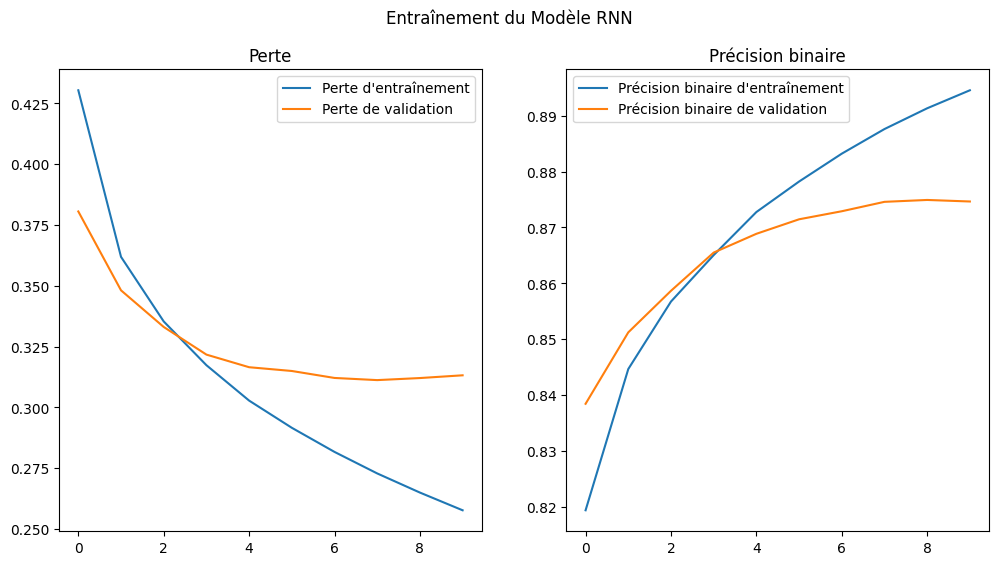

In [72]:
# Fonction pour plotter les résultats
def plot_training_history(history, title):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history["loss"], label="Perte d'entraînement")
    plt.plot(history["val_loss"], label="Perte de validation")
    plt.legend()
    plt.title("Perte")

    plt.subplot(1, 2, 2)
    plt.plot(history["binary_accuracy"], label="Précision binaire d'entraînement")
    plt.plot(history["val_binary_accuracy"], label="Précision binaire de validation")
    plt.legend()
    plt.title("Précision binaire")

    plt.suptitle(title)
    plt.show()

# Visualiser l'historique d'entraînement
plot_training_history(history.history, "Entraînement du Modèle RNN")